# 1. Meanshift algorithm
![](http://www.chioka.in/meanshift-algorithm-for-the-rest-of-us-python/)  

<img src='rc/meanshift.png' alt='meanshift' width="640" height="480">

① 각 datapoint x에 대하여, bandwidth 내에 있는 이웃 point들을 탐색  
  
  - 주로 가우시안 커널을 사용 (가까운 datapoint가 멀리 있는 datapoint보다 더 큰 영향을 미침)
$$ 
Gaussian = \frac{1}{\sigma \sqrt{2 \pi}} e^{-{1 \over 2}}{\big( \frac{x-\mu}{\sigma} \big)}^2
$$

<br>

② 다음 수식을 이용하여 meanshift $m(x)$를 계산함
$$
m(x_t)= \frac{\sum_{i} K(x_i - x) \, x_i}{\sum_i K(x_i - x)}
$$

  - $K(x_i - x)$를 $w_i$로 치환하면,  

$$
\bar{x} = \frac{\sum_{i} w_i x_i}{\sum_i w_i}
$$

  - 즉, meanshift는 중심점 x에 영향을 주는 datapoint들의 **weighted average(가중치 평균)**으로 계산됨  
  
<br>

③ 각 datapoint x에 대하여, 새로운 $\bar{x}$로 업데이트 함  
$$
x_{t+1} = x_t + m(x_t)
$$

<br>

④ <u>1) 설정한 반복 횟수를 채우거나</u>, <u>2) 중심점이 더 이상 거의 움직이지 않을 때</u>까지 ① ~ ④를 반복  

### [reference]
- [link #1 - meanshift and object tracking](https://darkpgmr.tistory.com/64?category=460965)

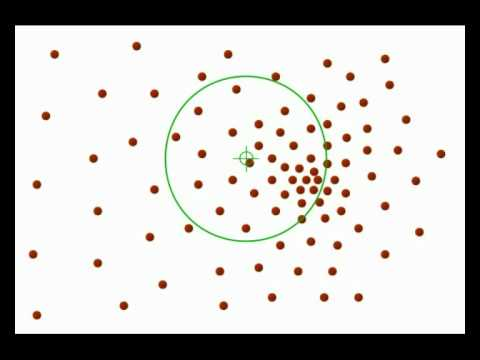

In [5]:
from IPython.display import YouTubeVideo
YouTubeVideo('kmaQAsotT9s')

# 2. Basic code
## 1) Sample data

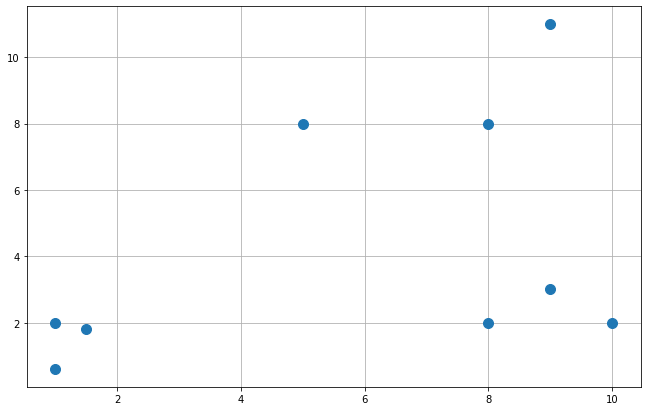

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## 샘플 데이터
X = np.array([[1, 2],
              [1.5, 1.8],
              [5, 8],
              [8, 8],
              [1, 0.6],
              [9, 11],
              [8, 2],
              [10, 2],
              [9, 3]])

plt.figure(figsize=(11,7))
plt.scatter(X[:,0], X[:,1], s=100, zorder=2)
plt.grid()
plt.show()

## 2) Meanshift

In [2]:
import numpy as np

def euclidean_distance(a, b):
    return np.sqrt(np.sum((a-b)**2))

def gaussian_kernel(distance, sigma):
    return (1/(sigma*np.sqrt(2*np.pi))) * np.exp(-0.5*((distance / sigma))**2)

def meanshift(data, bandwidth=4, n_iterations=10, epsilon=0.01):   
    ## 초기값 설정
    prev_centroids = data.copy()
    centroids = data.copy()

    ## 종료 조건 1 - 최대 n_iterations 만큼 반복
    for i in range(n_iterations):      
        print('Iteration %d' %i)
        new_centroids = np.empty((2,))
        
        for k, centroid in enumerate(centroids):
            ## 현재 중심점과의 거리가 bandwidth 내에 있는 datapoint들을 별도의 리스트에 저장
            in_bandwidth = []
            for point in data:
                if euclidean_distance(point, centroid) <= bandwidth:
                    in_bandwidth.append(point)

            ## bandwidth 내에 있는 데이터들을 기반으로 새로운 중심점 계산
            numerator = 0    # 분자
            denominator = 0  # 분모
            for inPoint in in_bandwidth:
                distance = euclidean_distance(inPoint, centroid)
                weight = gaussian_kernel(distance, bandwidth)
                numerator += (weight*inPoint)
                denominator += weight
            new_centroid = numerator / denominator
            
            ## 중심점 업데이트
            centroids[k] = new_centroid
        
        ## 종료 조건 2 - 새로운 중심점과 이전 중심점과의 차이가 epsilon보다 크지 않으면 stop!
        if all(euclidean_distance(new, prev) < epsilon for new, prev in zip(centroids, prev_centroids)):
            break
        
        prev_centroids = centroids.copy()
    
    return np.unique(centroids.astype('float16'), axis=0)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6

[[1.168 1.472]
 [7.363 8.94 ]
 [9.    2.338]]


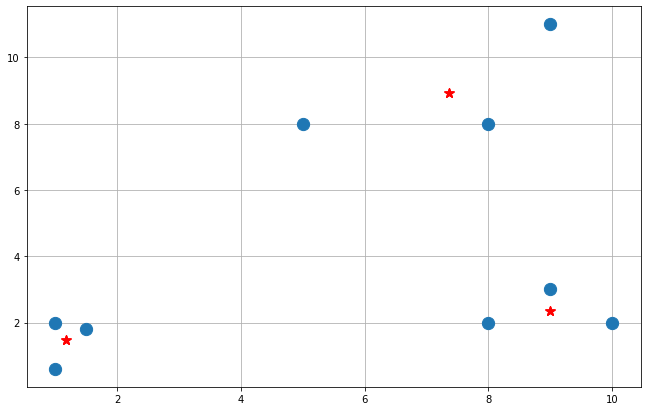

In [3]:
## meanshift 수행
centroids = meanshift(X)
print()
print(centroids)

## 결과 그리기
plt.figure(figsize=(11,7))
plt.scatter(X[:,0], X[:,1], s=150, zorder=2)
for c in centroids:
    plt.scatter(centroids[:,0], centroids[:,1], color='r', marker='*',  s=100, zorder=2)
plt.grid()
plt.show()

# 3. Applications
## 1) object tracking
[](https://www.bogotobogo.com/python/OpenCV_Python/python_opencv3_mean_shift_tracking_segmentation.php)
[](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_video/py_meanshift/py_meanshift.html)

In [4]:
import numpy as np
import cv2

## 1) 첫 frame에서 초기 window 설정
cap = cv2.VideoCapture('slow_traffic_small.mp4')
ret,frame = cap.read()

x,y,w,h = 310,188,41,41
track_window = (x,y,w,h)
roi = frame[y:y+h, x:x+w]

## 2) histogram backprojection을 위한 모델 히스토그램 계산
hsv_m =  cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv_m, np.array([0,60,32]), np.array([180,255,255]))
hist_m = cv2.calcHist([hsv_m],[0], mask, [180], [0,180])
hist_m = (hist_m - hist_m.min()) / (hist_m.max() - hist_m.min())


## 3) meanshift 종료 조건 설정 (10번 반복하거나 중심 이동량이 1보다 작은 경우)
term_crit = (cv2.TERM_CRITERIA_COUNT | cv2.TERM_CRITERIA_EPS, 10, 1)


while True:    # 매 프레임마다 처리
    ret ,frame = cap.read()
    if ret == False:
        break
        
    ## 4) histogram backprojection을 통해 원하는 영역만 남김
    ## https://docs.opencv.org/2.4/modules/imgproc/doc/histograms.html#calcbackproject
    hsv_i = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    dst = cv2.calcBackProject(images = [hsv_i],                # 입력 영상 리스트
                              channels = [0],                  # histogram backproject하고자 하는 영상 채널
                              hist = hist_m,                   # 기준이 되는 모델 히스토그램
                              ranges = [0,180],                # 히스토그램 bin의 범위
                              scale = 1)                       # 출력값의 스케일
    
    ## 5) backprojection 결과를 입력으로 meanshift 수행
    ## https://docs.opencv.org/2.4/modules/video/doc/motion_analysis_and_object_tracking.html#meanshift
    ret, track_window = cv2.meanShift(probImage = dst,         # 물체 히스토그램의 backprojection 결과
                                      window = track_window,   # 초기 윈도우
                                      criteria = term_crit)    # 탐색 알고리즘의 반복을 멈추기 위한 기준

    
    ## 6) 결과 그리기
    x,y,w,h = track_window
    img2 = cv2.rectangle(frame, (x,y), (x+w,y+h), 255, 2)
    cv2.imshow('tracking',img2)

    k = cv2.waitKey(0) & 0xff
    if k == 27:
        break

cv2.destroyAllWindows()
cap.release()

## 2) Image segmentation (posterization)

In [5]:
import cv2

img = cv2.imread('villa.jpg')
luv = cv2.cvtColor(img, cv2.COLOR_BGR2Luv)

## meanshift segmentation
## https://docs.opencv.org/2.4/modules/imgproc/doc/filtering.html#pyrmeanshiftfiltering
shifted = cv2.pyrMeanShiftFiltering(src = luv,  # 8-bit, 3-channel 이미지
                                    sp = 11,    # 공간 윈도우 반지름
                                    sr = 31)    # 컬러 윈도우 반지름

shifted = cv2.cvtColor(shifted, cv2.COLOR_Luv2BGR)
cv2.imshow('original', img)
cv2.imshow('shifted', shifted)

cv2.waitKey()
cv2.destroyAllWindows()

## 3) Image segmentation (watershed)
![](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_watershed/py_watershed.html)
![](https://opencv-python.readthedocs.io/en/latest/doc/27.imageWaterShed/imageWaterShed.html)
![](https://webnautes.tistory.com/1281)
<img src='rc/watershed.png' alt='watershed' width="400" heigh="280">

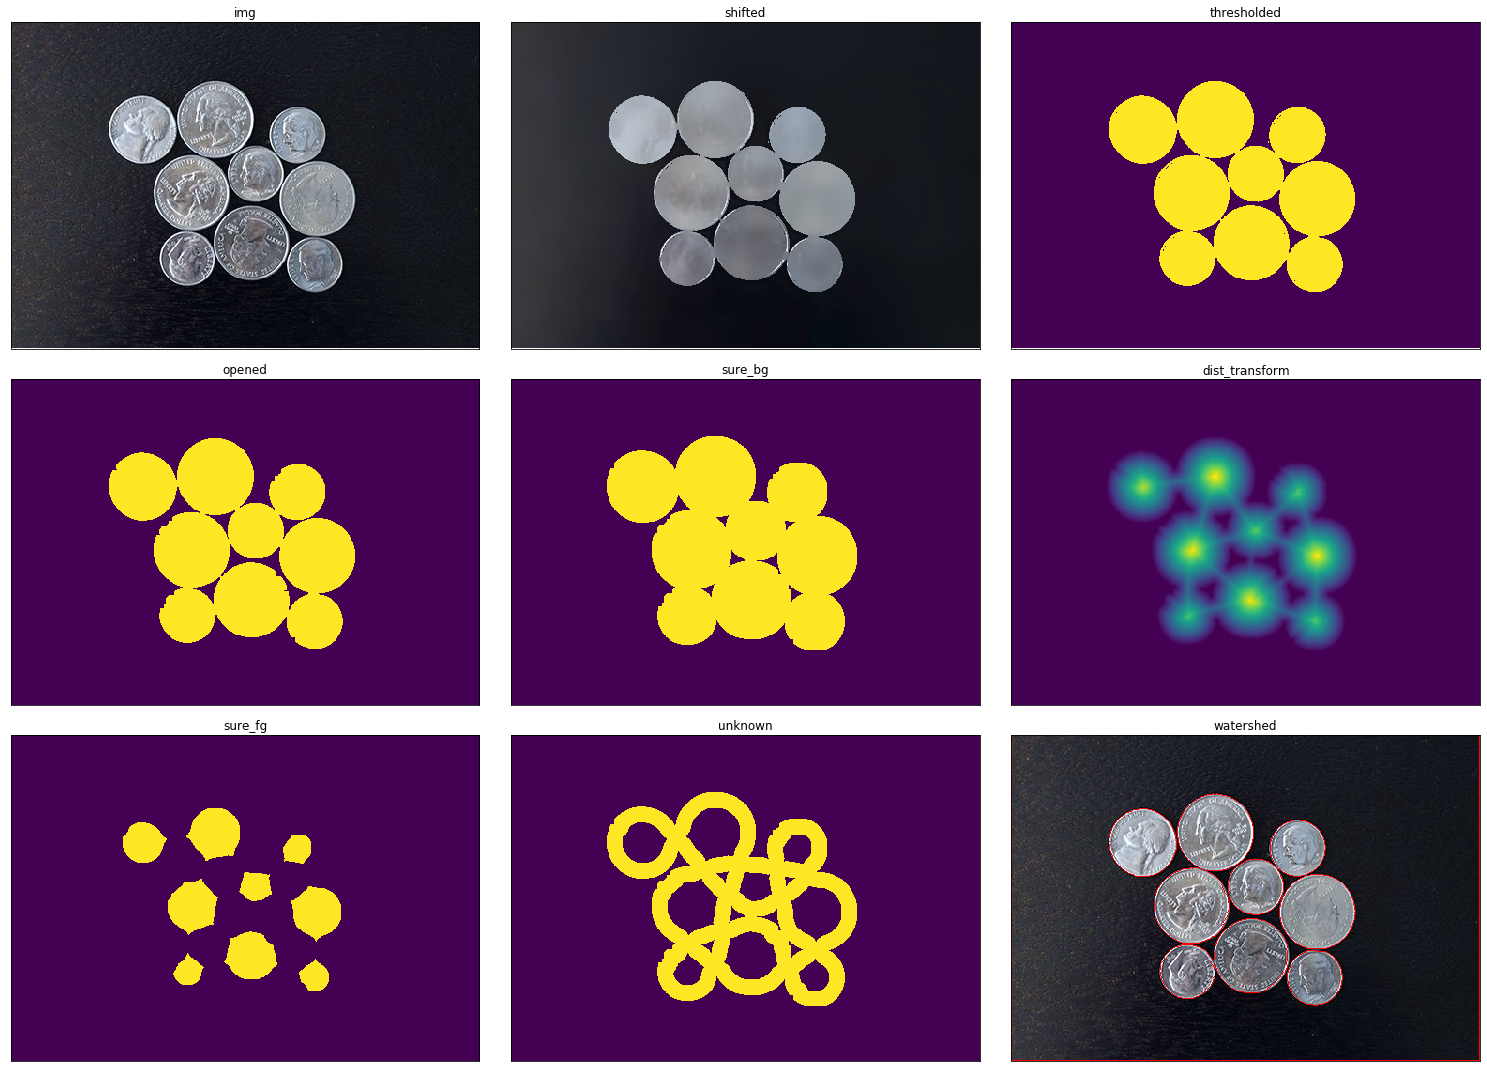

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

img = cv2.imread('coins.jpg')

## 1) RGB -> LUV 색공간 변환
luv = cv2.cvtColor(img, cv2.COLOR_BGR2Luv)


## 2) meanshift segmentation
## https://docs.opencv.org/2.4/modules/imgproc/doc/filtering.html#pyrmeanshiftfiltering
shifted = cv2.pyrMeanShiftFiltering(src =luv,  # 8-bit, 3-channel 이미지
                                    sp = 11,   # 공간 윈도우 반지름
                                    sr = 51)   # 컬러 윈도우 반지름


## 3) Otsu 이진화를 통한 foreground 영역 검출
## https://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html#threshold
shifted = cv2.cvtColor(shifted, cv2.COLOR_Luv2BGR)
gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
_, thresholded = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)


## 4) 모폴로지 연산을 사용하여 foreground 영역 노이즈 영역 제거 + foreground 영역 확장
## https://docs.opencv.org/2.4/modules/imgproc/doc/filtering.html#morphologyex
kernel = np.ones((3,3), np.uint8)
opened = cv2.morphologyEx(thresholded, cv2.MORPH_OPEN, kernel, iterations=2)
sure_bg = cv2.dilate(opened, kernel,iterations=2)


## 5) 거리 변환 + 이진화를 사용하여 확실한 foreground 영역 검출
## https://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html#distancetransform
dist_transform = cv2.distanceTransform(sure_bg, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.4*dist_transform.max(), 255, cv2.THRESH_BINARY)
sure_fg = np.uint8(sure_fg)

## 6) foreground인지 background인지 모호한 영역 설정 => unknown
unknown = cv2.subtract(sure_bg, sure_fg)

## 7) 확실한 foreground 영역 labeling 및 marker 설정
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1                  # marker는 watershed에서 seed로 사용됨
markers[unknown == 255] = 0            # marker에 unknown 영역 설정

## 8) watershed 알고리즘 수행 
## https://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html#watershed
labels = cv2.watershed(img, markers)   ## 워터셰드 결과 label
                                       # -1: foreground 외곽선
                                       # 1~: 영역별 labeling

                
## 9) 결과 그리기
result = img.copy()
result[labels == -1] = (255,0,0)  # 외곽선

images = [img, shifted, thresholded,  opened, sure_bg, dist_transform, sure_fg, unknown, result]
titles = ['img','meanshift','thresholded','opened','sure_bg','dist_transform','sure_fg','unknown','watershed']

plt.figure(figsize=(21,15))
for i in range(len(images)):
    plt.subplot(3,3,i+1),
    plt.imshow(images[i])
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()
plt.savefig('result.png')
plt.show()